In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from PIL import Image

from tqdm import tqdm_notebook as tqdm

# Dataset Preparation

In [4]:
from torch.utils.data import Dataset
from PIL import Image
import os

class HealthyDataset(Dataset):
    def __init__(self, img_dir, transform1=None, transform2=None):
        self.img_dir = img_dir  # Directory where the images are stored
        self.img_names = os.listdir(img_dir)  # List all files in the image directory
        self.transform1 = transform1  # First transformation to apply to the images
        self.transform2 = transform2  # Second transformation to apply to the images

        # Load and optionally transform all images in the directory
        self.imgs = []  # List to store the loaded images
        for img_name in self.img_names:
            # Open each image
            img = Image.open(os.path.join(img_dir, img_name))

            # Apply the first transformation if it is defined
            if self.transform1 is not None:
                img = self.transform1(img)

            # Add the (transformed) image to the list
            self.imgs.append(img)

    def __getitem__(self, index):
        # Method to get an image by index
        img = self.imgs[index]  # Retrieve the image from the list

        # Apply the second transformation if it is defined
        if self.transform2 is not None:
            img = self.transform2(img)

        # Return the possibly transformed image
        return img

    def __len__(self):
        # Method to get the total number of images
        return len(self.imgs)  # Return the length of the image list

In [5]:
def prepareData(batch_size):
    # Image Preprocessing
    transform1 = transforms.Compose([
        transforms.Resize(64),        # Resize the image to 64x64 pixels
    #     transforms.CenterCrop(64)     # Crop the image to a 64x64 square centered on the middle of the image
    ])

    # Data augmentation and conversion to tensor
    random_transforms = [transforms.RandomRotation(degrees=5)]  # Define random rotation transformation
    transform2 = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the images horizontally with a probability of 0.5
    #     transforms.RandomApply(random_transforms, p=0.3),  # Apply the random rotation with a probability of 0.3
        transforms.ToTensor(),  # Convert the images to PyTorch tensors
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the tensors
    ])

    # Creating the dataset
    train_dataset = HealthyDataset(img_dir='/kaggle/input/healthy-images/Healthy',
                               transform1=transform1,
                               transform2=transform2)

    # DataLoader for the dataset
    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,  # Load data in batches
                              shuffle=True,           # Shuffle the data to reduce model overfitting
                              num_workers=4)          # Number of subprocesses to use for data loading

    # Loading a batch of images
    imgs = next(iter(train_loader))  # Get the first batch of images
    imgs = imgs.numpy().transpose(0, 2, 3, 1)  # Convert the images from PyTorch tensor to numpy array and change the shape
    return train_loader, imgs

# Model

In [6]:
import torch.nn as nn

# Generator class
class Generator(nn.Module):
    def __init__(self, nz=128, channels=3):
        super(Generator, self).__init__()
        
        # Initialize input and output channels
        self.nz = nz
        self.channels = channels
        
        # Define a helper function to create a convolutional layer
        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0):
            block = [
                nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(n_output),
                nn.ReLU(inplace=True),
            ]
            return block

        # Build the model
        self.model = nn.Sequential(
            *convlayer(self.nz, 1024, 4, 1, 0), # First layer: Fully connected layer achieved through convolution.
            *convlayer(1024, 512, 4, 2, 1),    # Second layer
            *convlayer(512, 256, 4, 2, 1),     # Third layer
            *convlayer(256, 128, 4, 2, 1),     # Fourth layer
            *convlayer(128, 64, 4, 2, 1),      # Fifth layer
            nn.ConvTranspose2d(64, self.channels, 3, 1, 1), # Final layer to produce output with desired number of channels
            nn.Tanh() # Tanh activation function for the output
        )

    # Forward pass through the generator
    def forward(self, z):
        # Reshape input noise vector z to a batch of images
        z = z.view(-1, self.nz, 1, 1)
        img = self.model(z)
        return img

# Discriminator class
class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()
        
        # Initialize input channels
        self.channels = channels

        # Define a helper function to create a convolutional layer
        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0, bn=False):
            block = [nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False)]
            if bn:
                block.append(nn.BatchNorm2d(n_output))
            block.append(nn.LeakyReLU(0.2, inplace=True))
            return block

        # Build the model
        self.model = nn.Sequential(
            *convlayer(self.channels, 32, 4, 2, 1),  # First layer
            *convlayer(32, 64, 4, 2, 1),             # Second layer
            *convlayer(64, 128, 4, 2, 1, bn=True),   # Third layer with batch normalization
            *convlayer(128, 256, 4, 2, 1, bn=True),  # Fourth layer with batch normalization
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),  # Final layer: Fully connected layer through convolution
        )

    # Forward pass through the discriminator
    def forward(self, imgs):
        # Pass the images through the model
        out = self.model(imgs)
        # Flatten the output
        return out.view(-1, 1)

# Training

In [7]:
def show_generated_img(noises, netG, netD, epoch):
    
    print(f"\n Saving Model")
    print('*'* 10)
        # Save the Generator's state
    torch.save(netG.state_dict(), f'/kaggle/working/generator_ben_{epoch}.pth')  
    # 'netG.state_dict()' retrieves the state (weights and biases) of the generator network (netG).
    # This state is saved to a file named 'generator.pth'.
    # The '.pth' extension is commonly used for PyTorch model files.

    # Save the Discriminator's state
    torch.save(netD.state_dict(), f'/kaggle/working/discriminator_ben_{epoch}.pth')  
    # 'netD.state_dict()' retrieves the state (weights and biases) of the discriminator network (netD).
    # This state is saved to a file named 'discriminator.pth'.
    # The '.pth' extension is commonly used for PyTorch model files.

    # Generate images from the noise vectors using the generator
    gen_images = (netG(noises).to("cpu").clone().detach() + 1) / 2
    # 'netG(gen_z)' passes the noise vectors through the generator to produce a batch of images.
    # '.to("cpu")' moves the generated images to the CPU. This is necessary for converting them into numpy arrays later.
    # '.clone().detach()' creates a copy of the images and detaches them from the current computation graph.
    # '(... + 1) / 2' rescales the pixel values from the range [-1, 1] to [0, 1].
    # This rescaling is necessary because the generator often uses Tanh activation in the output layer, resulting in outputs in the range [-1, 1].

    # Convert the images to numpy arrays for visualization
    gen_images = gen_images.numpy().transpose(0, 2, 3, 1)  
    # '.numpy()' converts the tensor of generated images to a numpy array.
    # '.transpose(0, 2, 3, 1)' changes the shape of the array from [batch, channels, height, width] to [batch, height, width, channels].
    # This transposition is required for visualization purposes, as most visualization libraries expect the channel dimension to be last.
    
    # Create a figure for plotting the images
    fig = plt.figure(figsize=(25, 16))  
    # 'figsize=(25, 16)' sets the size of the figure to 25 inches wide and 16 inches tall.
    # This large size helps in better visualization of multiple images.

    # Loop through the generated images
    for ii, img in enumerate(gen_images):
        # Add a subplot for each image in the figure
        ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])  
        # '4, 8' means the grid will have 4 rows and 8 columns.
        # 'ii + 1' is the position of the subplot in the grid.
        # 'xticks=[]' and 'yticks=[]' remove the x and y axis tick marks for each subplot.

        # Display the image in the subplot
        plt.imshow(img)  
        # 'plt.imshow' displays the image. 'img' is the current image in the loop.

    # Show the complete figure with all subplots
    plt.show()

In [8]:
import matplotlib.pyplot as plt

def trainData(batch_size, nz, epochs, lr):
    train_loader, imgs = prepareData(batch_size)

    fig = plt.figure(figsize=(25, 16))

    # Loop through the images in the batch, limiting to the first 32 images
    for ii, img in enumerate(imgs[:32]):
        ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
        plt.imshow((img + 1) / 2)

    plt.show()
    # Creating the Generator network
    netG = Generator(nz).to(device)  
    # Initialize the Generator with the specified noise vector size (nz).
    # The .to(device) method moves the model to a GPU if available, otherwise to the CPU.

    # Creating the Discriminator network
    netD = Discriminator().to(device)
    # Initialize the Discriminator.
    # The .to(device) method moves the model to a GPU if available, otherwise to the CPU.

    # Setting up the loss function
    criterion = nn.BCELoss()  
    # Binary Cross Entropy Loss is used, typical for GANs as the discriminator outputs a binary classification (real or fake).

    # Setting up the Optimizer for the Discriminator
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))  
    # Use the Adam optimizer for the discriminator.
    # 'lr' is the learning rate, and 'betas' are the hyperparameters for the Adam optimizer.

    # Setting up the Optimizer for the Generator
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))  
    # Use the Adam optimizer for the generator, similar to the discriminator.

    # Creating a fixed noise vector for evaluating the Generator's performance
    fixed_noise = torch.randn(32, nz, 1, 1, device=device)  
    # Generate a fixed random noise vector with 25 samples, each of size 'nz'.
    # The noise vector is used to evaluate the generator's output.
    # The .to(device) method moves the noise vector to the same device as the model.
    # Loop over all epochs
    print('*'* 10)
    print(f"\n Starting Training with lr = {lr}, batch_size={batch_size}, epochs={epochs}, nz={nz}")
    print('*'* 10)
    for epoch in range(epochs):

        # Loop over the batches of images
#         for ii, real_images in tqdm(enumerate(train_loader), total=len(train_loader)):
        for ii, real_images in enumerate(train_loader):
            # Update Discriminator network:
            # ----------------------------
            netD.zero_grad()  # Reset gradients for the discriminator

            # Move real images to the appropriate device (GPU or CPU)
            real_images = real_images.to(device)

            # Create labels for real images
            batch_size = real_images.size(0)
            labels = torch.full((batch_size, 1), real_label, device=device)

            # Forward pass real images through D
            outputR = netD(real_images)

            # Generate fake images with G
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake = netG(noise)

            # Forward pass fake images through D
            outputF = netD(fake.detach())

            # Calculate loss for D and perform backward pass
            errD = (torch.mean((outputR - torch.mean(outputF) - labels) ** 2) + 
                    torch.mean((outputF - torch.mean(outputR) + labels) ** 2)) / 2
            errD.backward(retain_graph=True)
            optimizerD.step()

            # Update Generator network:
            # -------------------------
            netG.zero_grad()  # Reset gradients for the generator

            # Forward pass fake images through D again
            outputF = netD(fake)

            # Calculate loss for G and perform backward pass
            errG = (torch.mean((outputR - torch.mean(outputF) + labels) ** 2) +
                    torch.mean((outputF - torch.mean(outputR) - labels) ** 2)) / 2
            errG.backward()
            optimizerG.step()

            # Print statistics
#             if (ii+1) % (len(train_loader)//2) == 0:
#                 print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f'
#                       % (epoch + 1, epochs, ii+1, len(train_loader),
#                          errD.item(), errG.item()))

        # Show a generated image after each epoch
        if epoch%100 == 0:
            print('Generating images for:', epoch, ' epochs')
            show_generated_img(fixed_noise, netG, netD, epoch)
    
    print('*'* 10)
    print(f"\n Finished Training with lr = {lr}, batch_size={batch_size}, epochs={epochs}, nz={nz}")
    print('*'* 10)  
    
    print(f"\n Saving Model")
    print('*'* 10)
        # Save the Generator's state
    torch.save(netG.state_dict(), f'/kaggle/working/generator_ben__{lr}_{batch_size}_{epochs}_{nz}.pth')  
    # 'netG.state_dict()' retrieves the state (weights and biases) of the generator network (netG).
    # This state is saved to a file named 'generator.pth'.
    # The '.pth' extension is commonly used for PyTorch model files.

    # Save the Discriminator's state
    torch.save(netD.state_dict(), f'/kaggle/working/discriminator_ben_{lr}_{batch_size}_{epochs}_{nz}.pth')  
    # 'netD.state_dict()' retrieves the state (weights and biases) of the discriminator network (netD).
    # This state is saved to a file named 'discriminator.pth'.
    # The '.pth' extension is commonly used for PyTorch model files.
    
    print('*'* 10)
    print(f"\n Generating Images with lr = {lr}, batch_size={batch_size}, epochs={epochs}, nz={nz}")
    print('*'* 10)
    
    # Generate random noise vectors
    gen_z = torch.randn(32, nz, 1, 1, device=device)  
    # This creates a batch of 32 random noise vectors, each of size 'nz'.
    # The noise vectors are the input to the generator.
    # The dimensions of the tensor are [batch_size, nz, 1, 1].
    # 'device=device' ensures that the operation is performed on the same device (GPU/CPU) as the model.

    # Generate images from the noise vectors using the generator
    gen_images = (netG(gen_z).to("cpu").clone().detach() + 1) / 2
    # 'netG(gen_z)' passes the noise vectors through the generator to produce a batch of images.
    # '.to("cpu")' moves the generated images to the CPU. This is necessary for converting them into numpy arrays later.
    # '.clone().detach()' creates a copy of the images and detaches them from the current computation graph.
    # '(... + 1) / 2' rescales the pixel values from the range [-1, 1] to [0, 1].
    # This rescaling is necessary because the generator often uses Tanh activation in the output layer, resulting in outputs in the range [-1, 1].

    # Convert the images to numpy arrays for visualization
    gen_images = gen_images.numpy().transpose(0, 2, 3, 1)  
    # '.numpy()' converts the tensor of generated images to a numpy array.
    # '.transpose(0, 2, 3, 1)' changes the shape of the array from [batch, channels, height, width] to [batch, height, width, channels].
    # This transposition is required for visualization purposes, as most visualization libraries expect the channel dimension to be last.
    
    # Create a figure for plotting the images
    fig = plt.figure(figsize=(25, 16))  
    # 'figsize=(25, 16)' sets the size of the figure to 25 inches wide and 16 inches tall.
    # This large size helps in better visualization of multiple images.

    # Loop through the generated images
    for ii, img in enumerate(gen_images):
        # Add a subplot for each image in the figure
        ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])  
        # '4, 8' means the grid will have 4 rows and 8 columns.
        # 'ii + 1' is the position of the subplot in the grid.
        # 'xticks=[]' and 'yticks=[]' remove the x and y axis tick marks for each subplot.

        # Display the image in the subplot
        plt.imshow(img)  
        # 'plt.imshow' displays the image. 'img' is the current image in the loop.

    # Show the complete figure with all subplots
    plt.show()
    
    
    print('*'* 10)
    print(f"\n Saving Images with lr = {lr}, batch_size={batch_size}, epochs={epochs}, nz={nz}")
    print('*'* 10)
    
    if not os.path.exists(f'/kaggle/working/images_{lr}_{batch_size}_{epochs}_{nz}'):
        os.mkdir(f'/kaggle/working/images_{lr}_{batch_size}_{epochs}_{nz}')  
        # '../output_images' is the directory where generated images will be saved.
        # 'os.mkdir' creates the directory if it does not already exist.

    # Define batch size for image generation and total number of images to generate
    im_batch_size = 1  # Number of images to generate in each batch.
    n_images = 100    # Total number of images to generate.

    # Generate and save images in batches
    for i_batch in range(0, n_images, im_batch_size):
        # Generate a batch of noise vectors
        gen_z = torch.randn(im_batch_size, nz, 1, 1, device=device)  
        # 'torch.randn' generates a tensor of random values from a normal distribution.
        # The tensor has dimensions [im_batch_size, nz, 1, 1].

        # Generate images from the noise vectors
        gen_images = (netG(gen_z) + 1) / 2  
        # 'netG(gen_z)' generates a batch of images.
        # '(... + 1) / 2' rescales the images from [-1, 1] to [0, 1].

        # Prepare images for saving
        images = gen_images.to("cpu").clone().detach()  
        # Move images to CPU and detach from computation graph.
        images = images.numpy().transpose(0, 2, 3, 1)  
        # Convert to numpy array and change shape from [batch, channels, height, width] to [batch, height, width, channels].

        # Save each image in the batch to disk
        for i_image in range(gen_images.size(0)):
            # Construct the file path
            image_path = os.path.join(f'/kaggle/working/images_{lr}_{batch_size}_{epochs}_{nz}', f'image_{i_batch+i_image:05d}.png')  
            # 'f'image_{i_batch+i_image:05d}.png'' formats the filename with leading zeros.

            # Save the image
            save_image(gen_images[i_image, :, :, :], image_path)  
            # 'save_image' saves the individual image to the specified path.

# Hyperparam Tuning

In [9]:
nz_range = [30]  # Adjust the range and number of points as needed
epochs_range = [1000]  # Adjust the range and number of points as needed
lr_sizes = [0.001]  # Adjust the range and number of points as needed
batch_size_range = [16]  # You might want to keep batch size as specific values
# Possible values for batch_size, epochs, and nz
batch_sizes = batch_size_range  # Add more values as needed
epochs_values = epochs_range  # Add more values as needed
nz_values = nz_range  # Add more values as needed


Training with lr = 0.001, batch_size=16, epochs=1000, nz=30


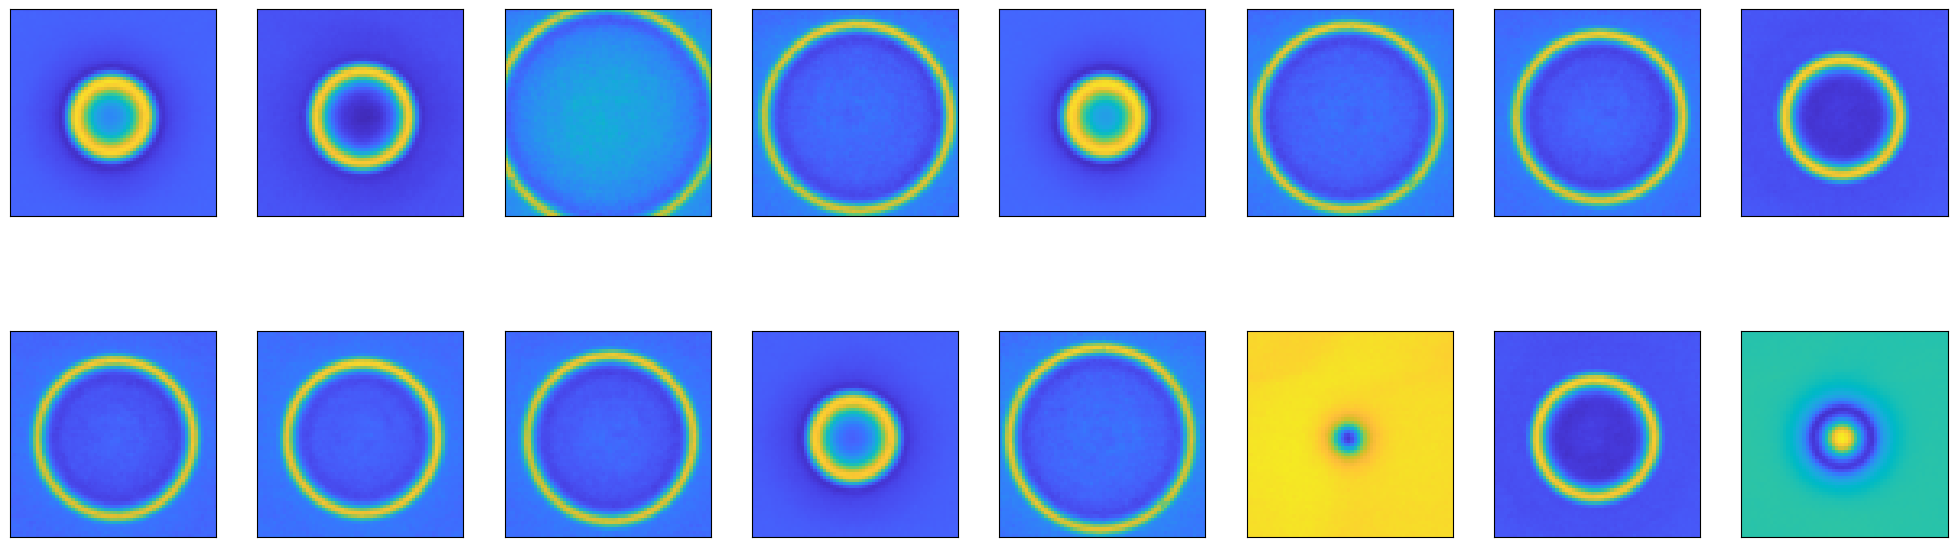

**********

 Starting Training with lr = 0.001, batch_size=16, epochs=1000, nz=30
**********
Generating images for: 0  epochs

 Saving Model
**********


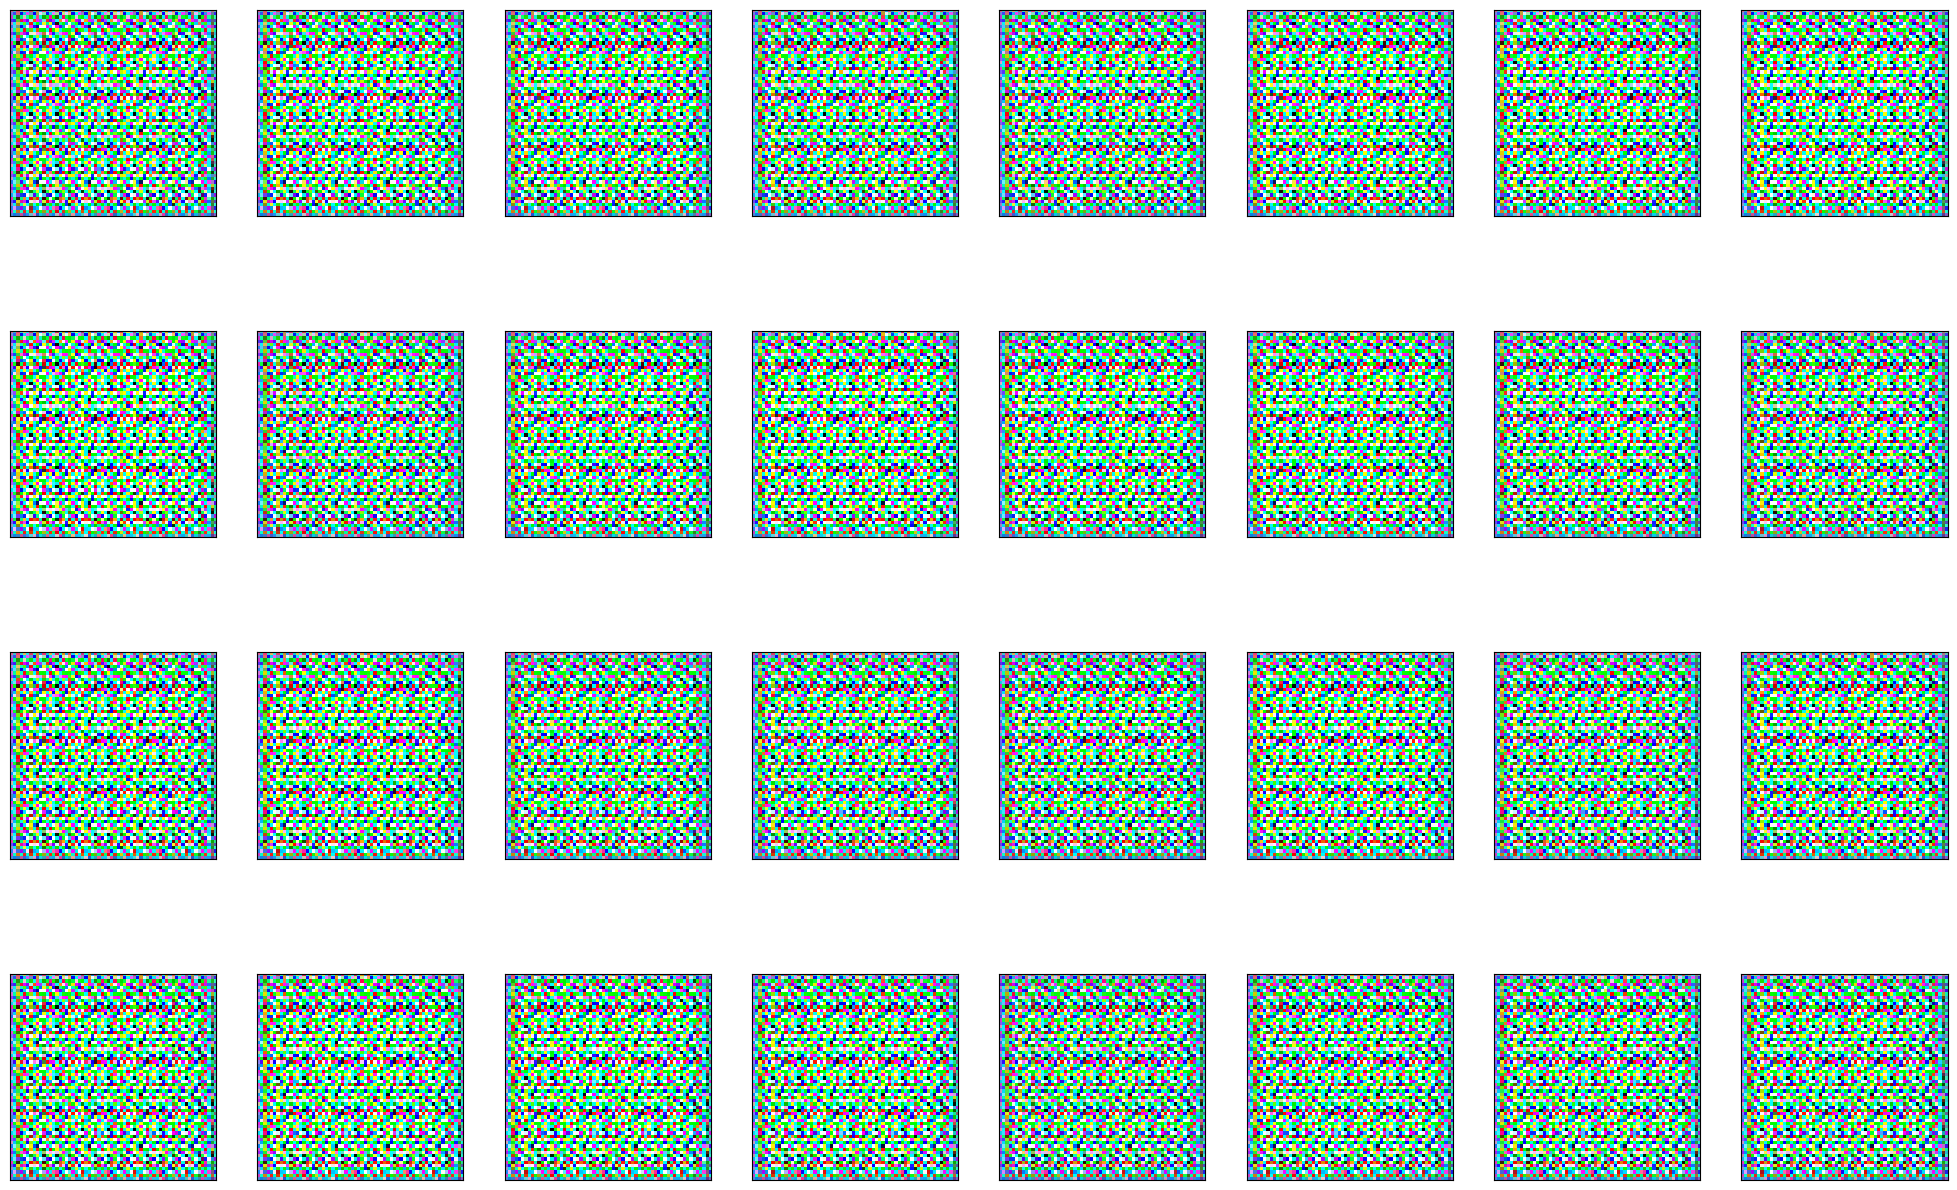

Generating images for: 100  epochs

 Saving Model
**********


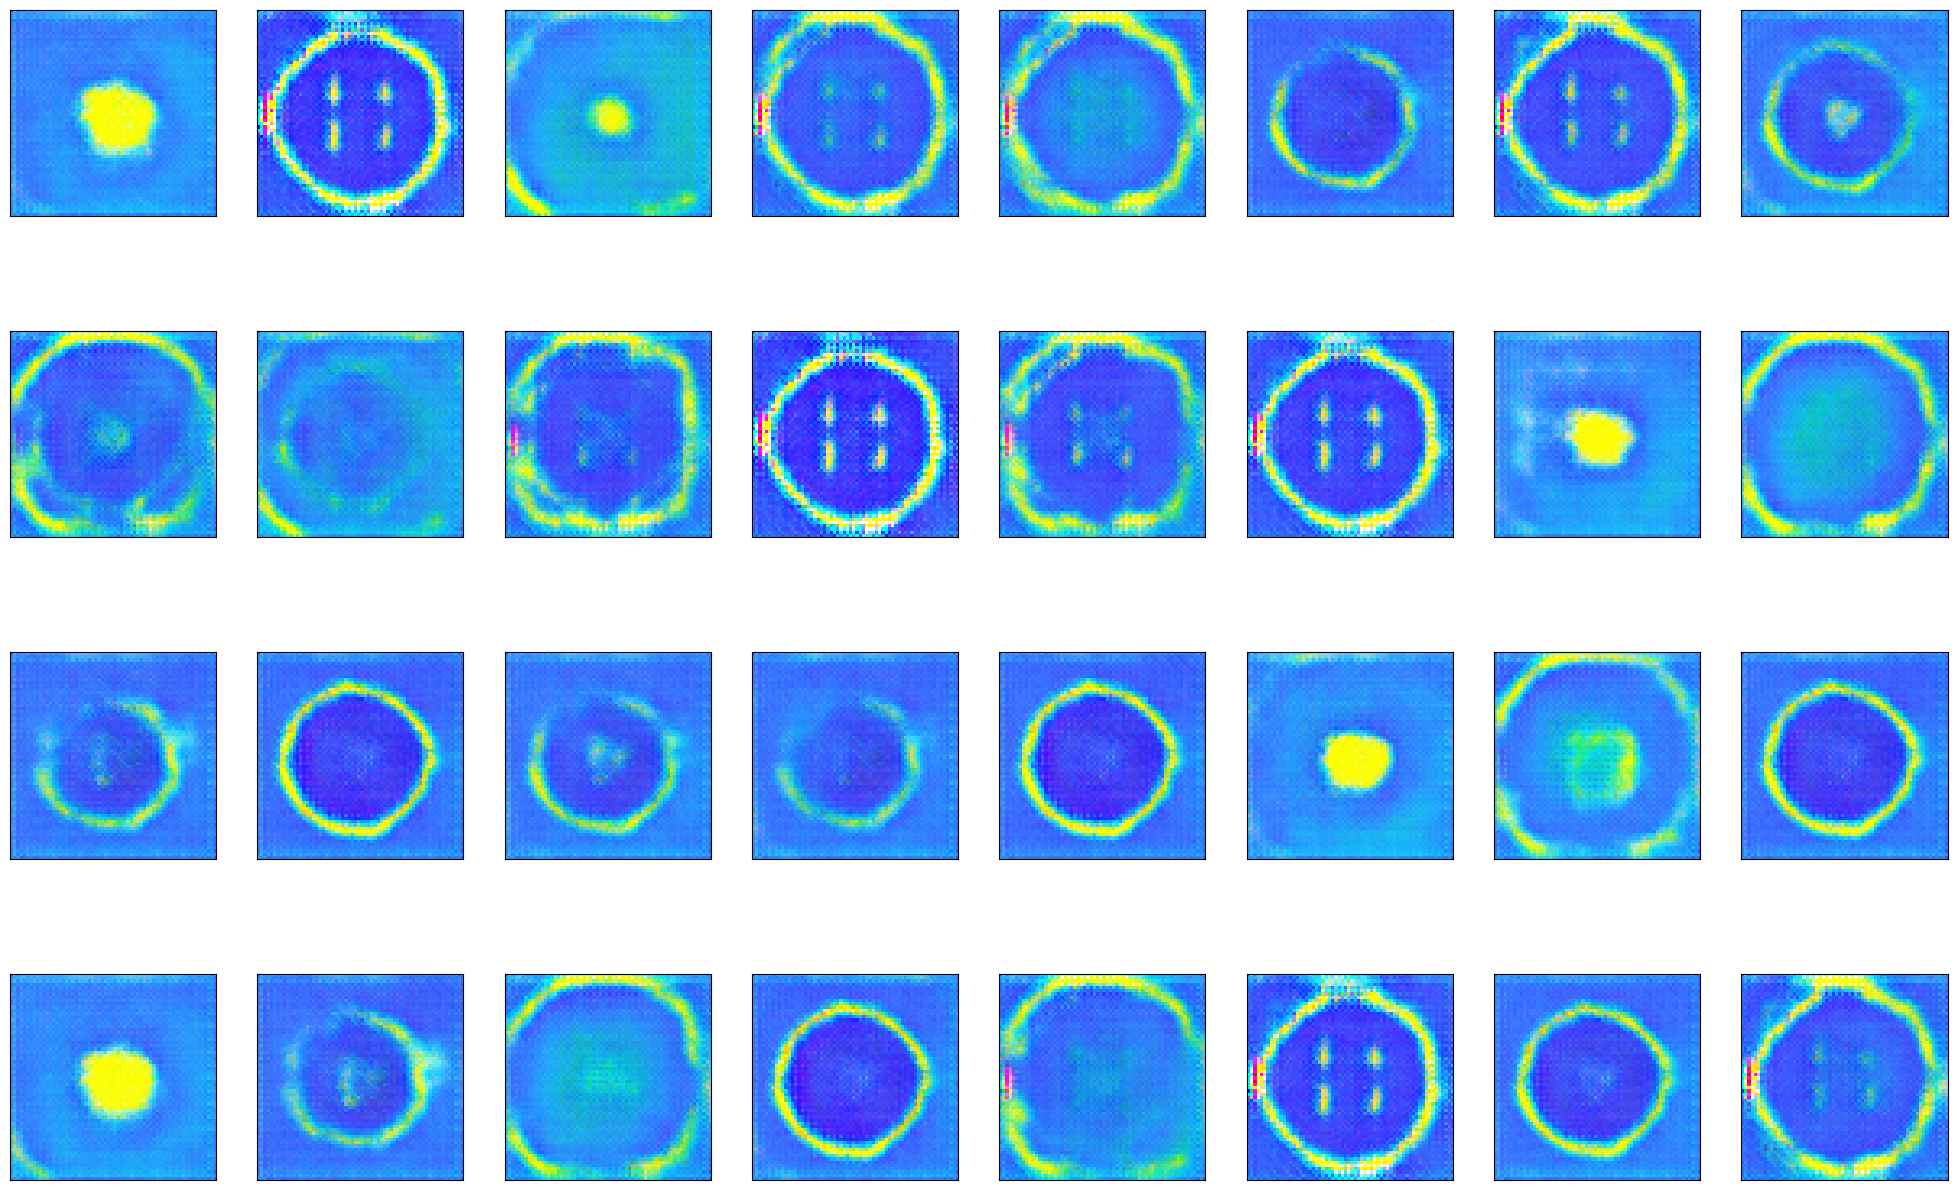

Generating images for: 200  epochs

 Saving Model
**********


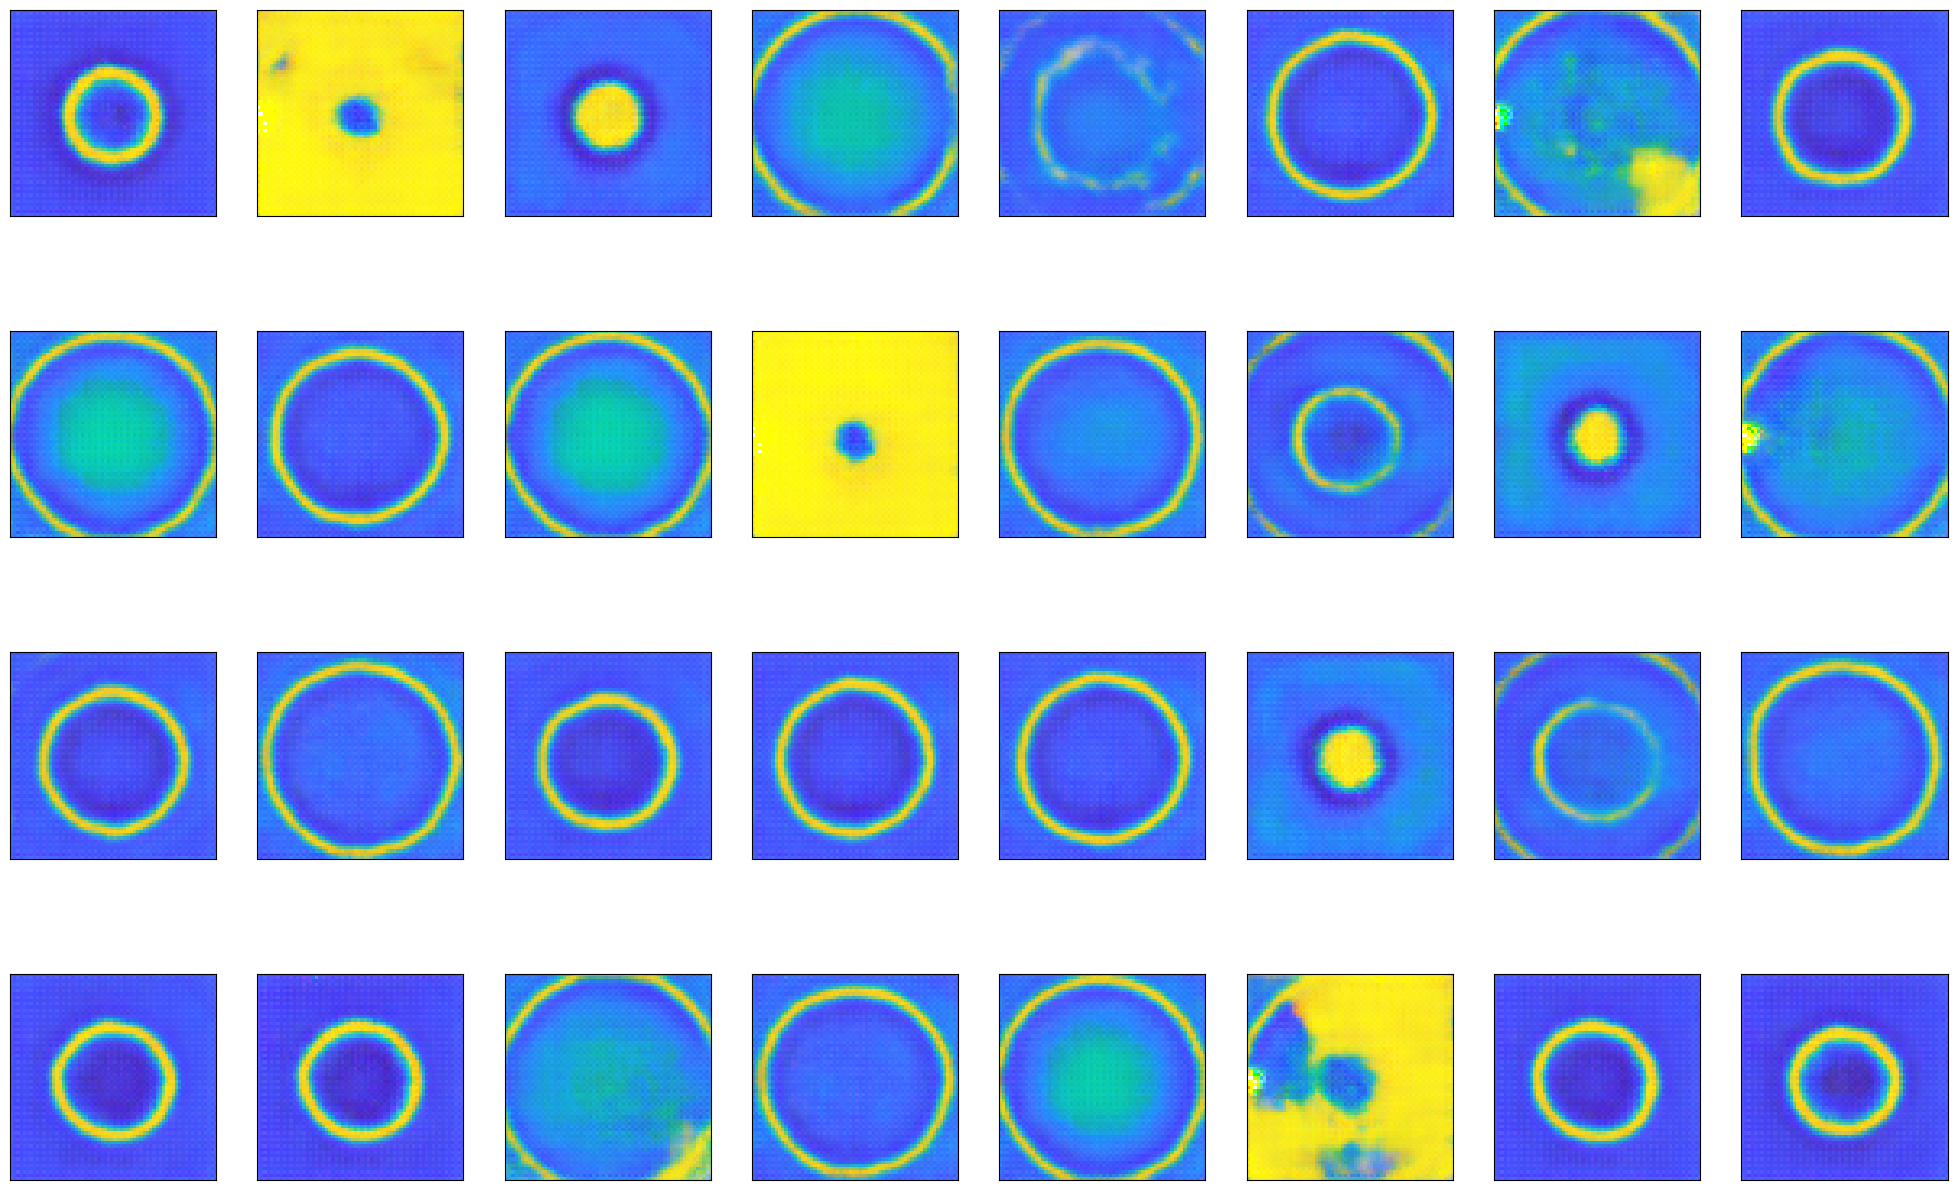

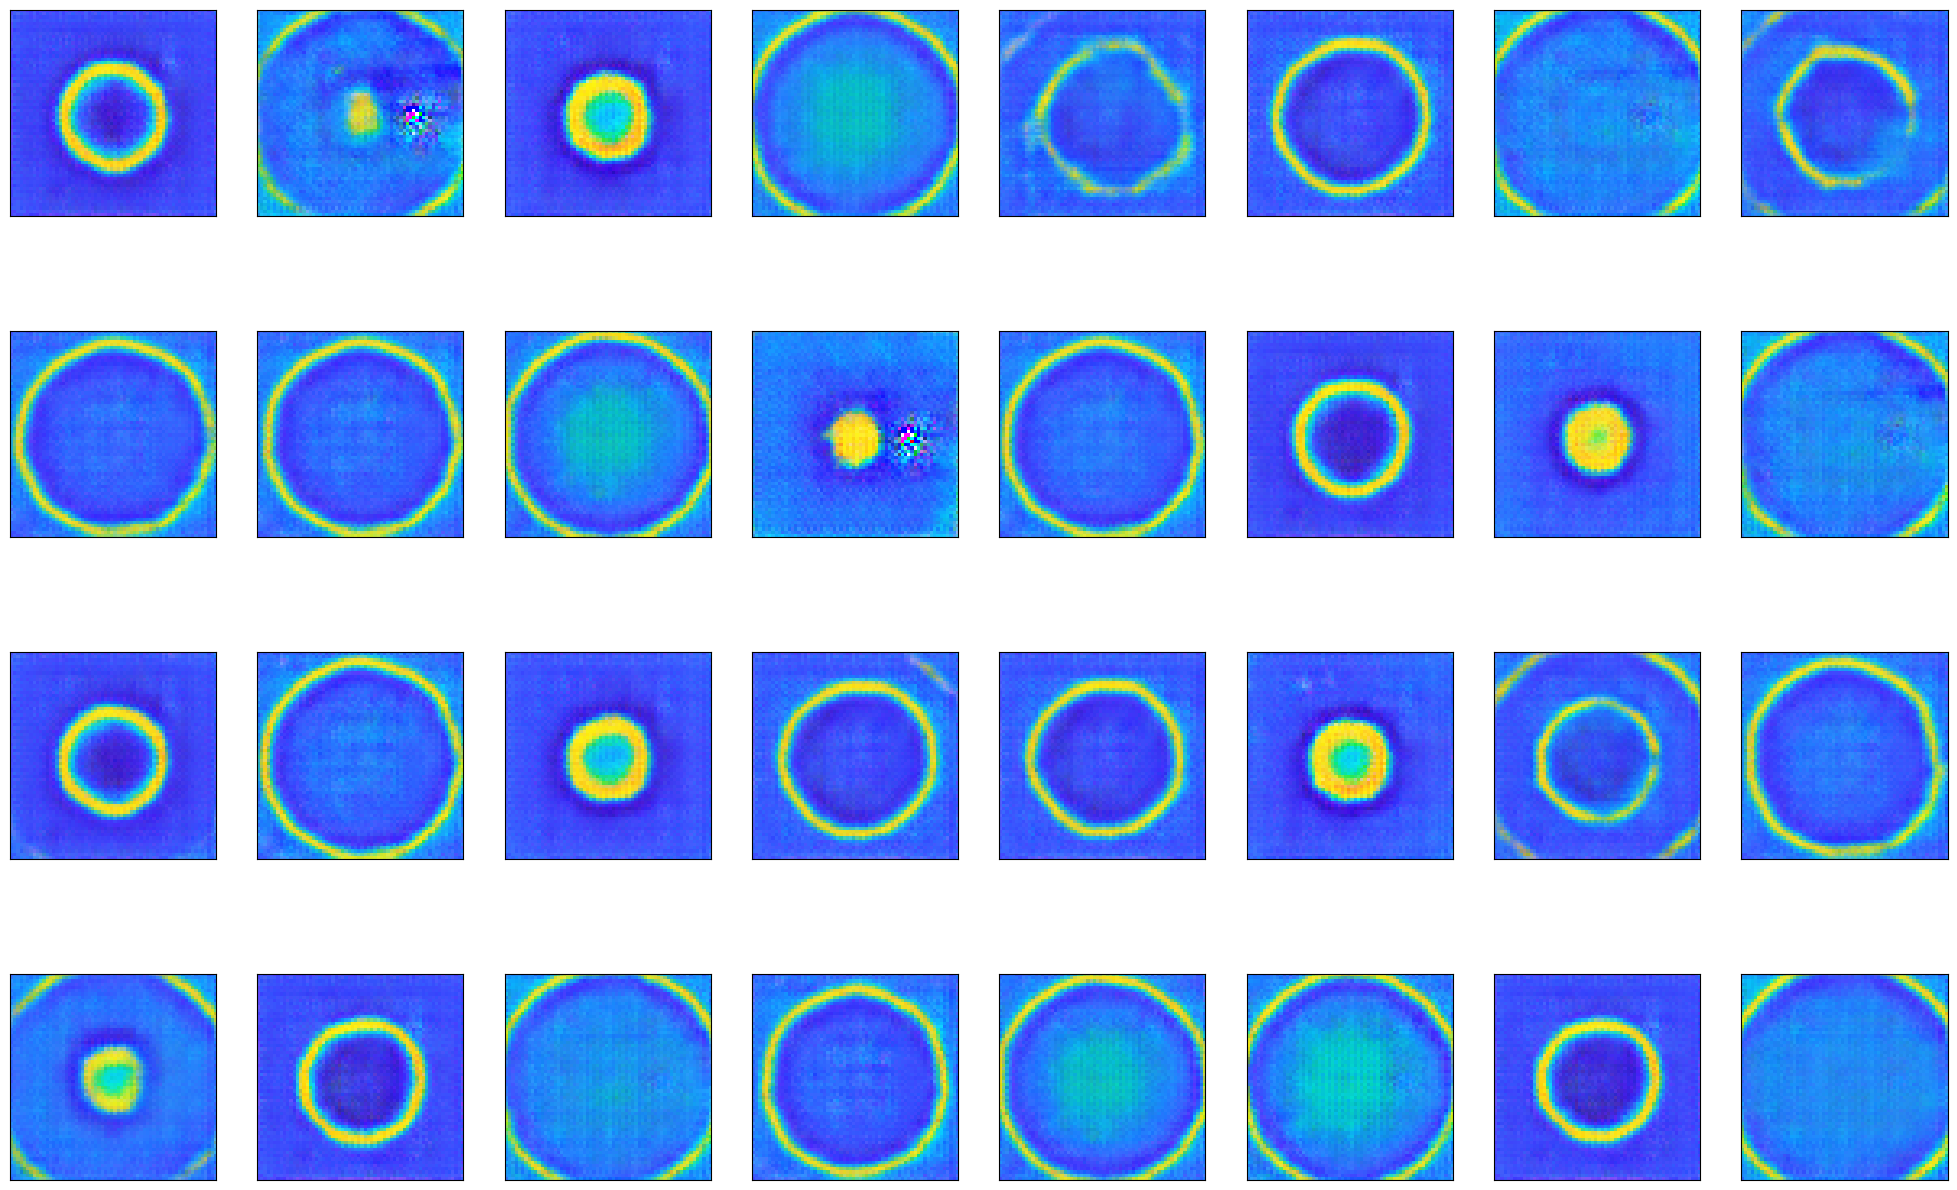

Generating images for: 400  epochs

 Saving Model
**********


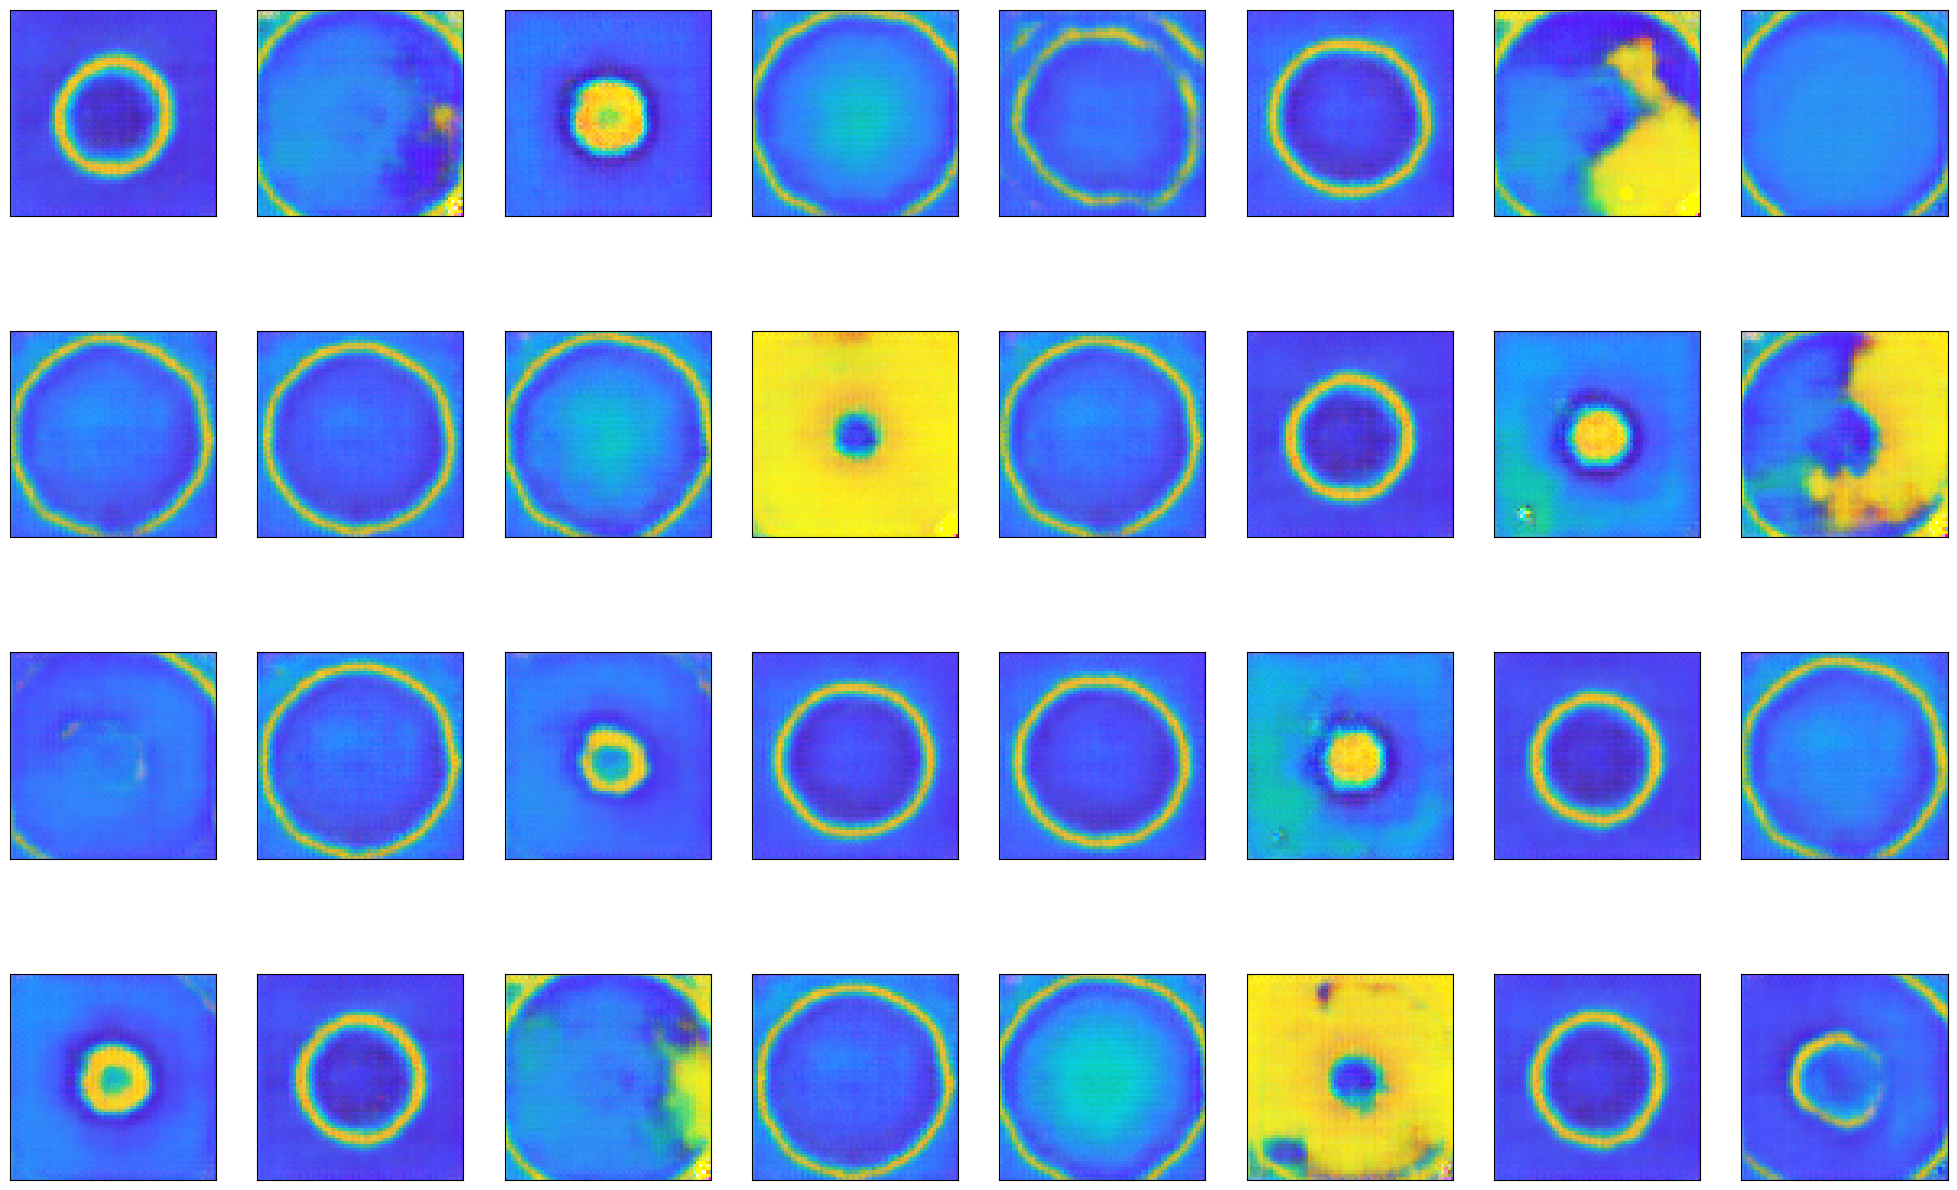

Generating images for: 500  epochs

 Saving Model
**********


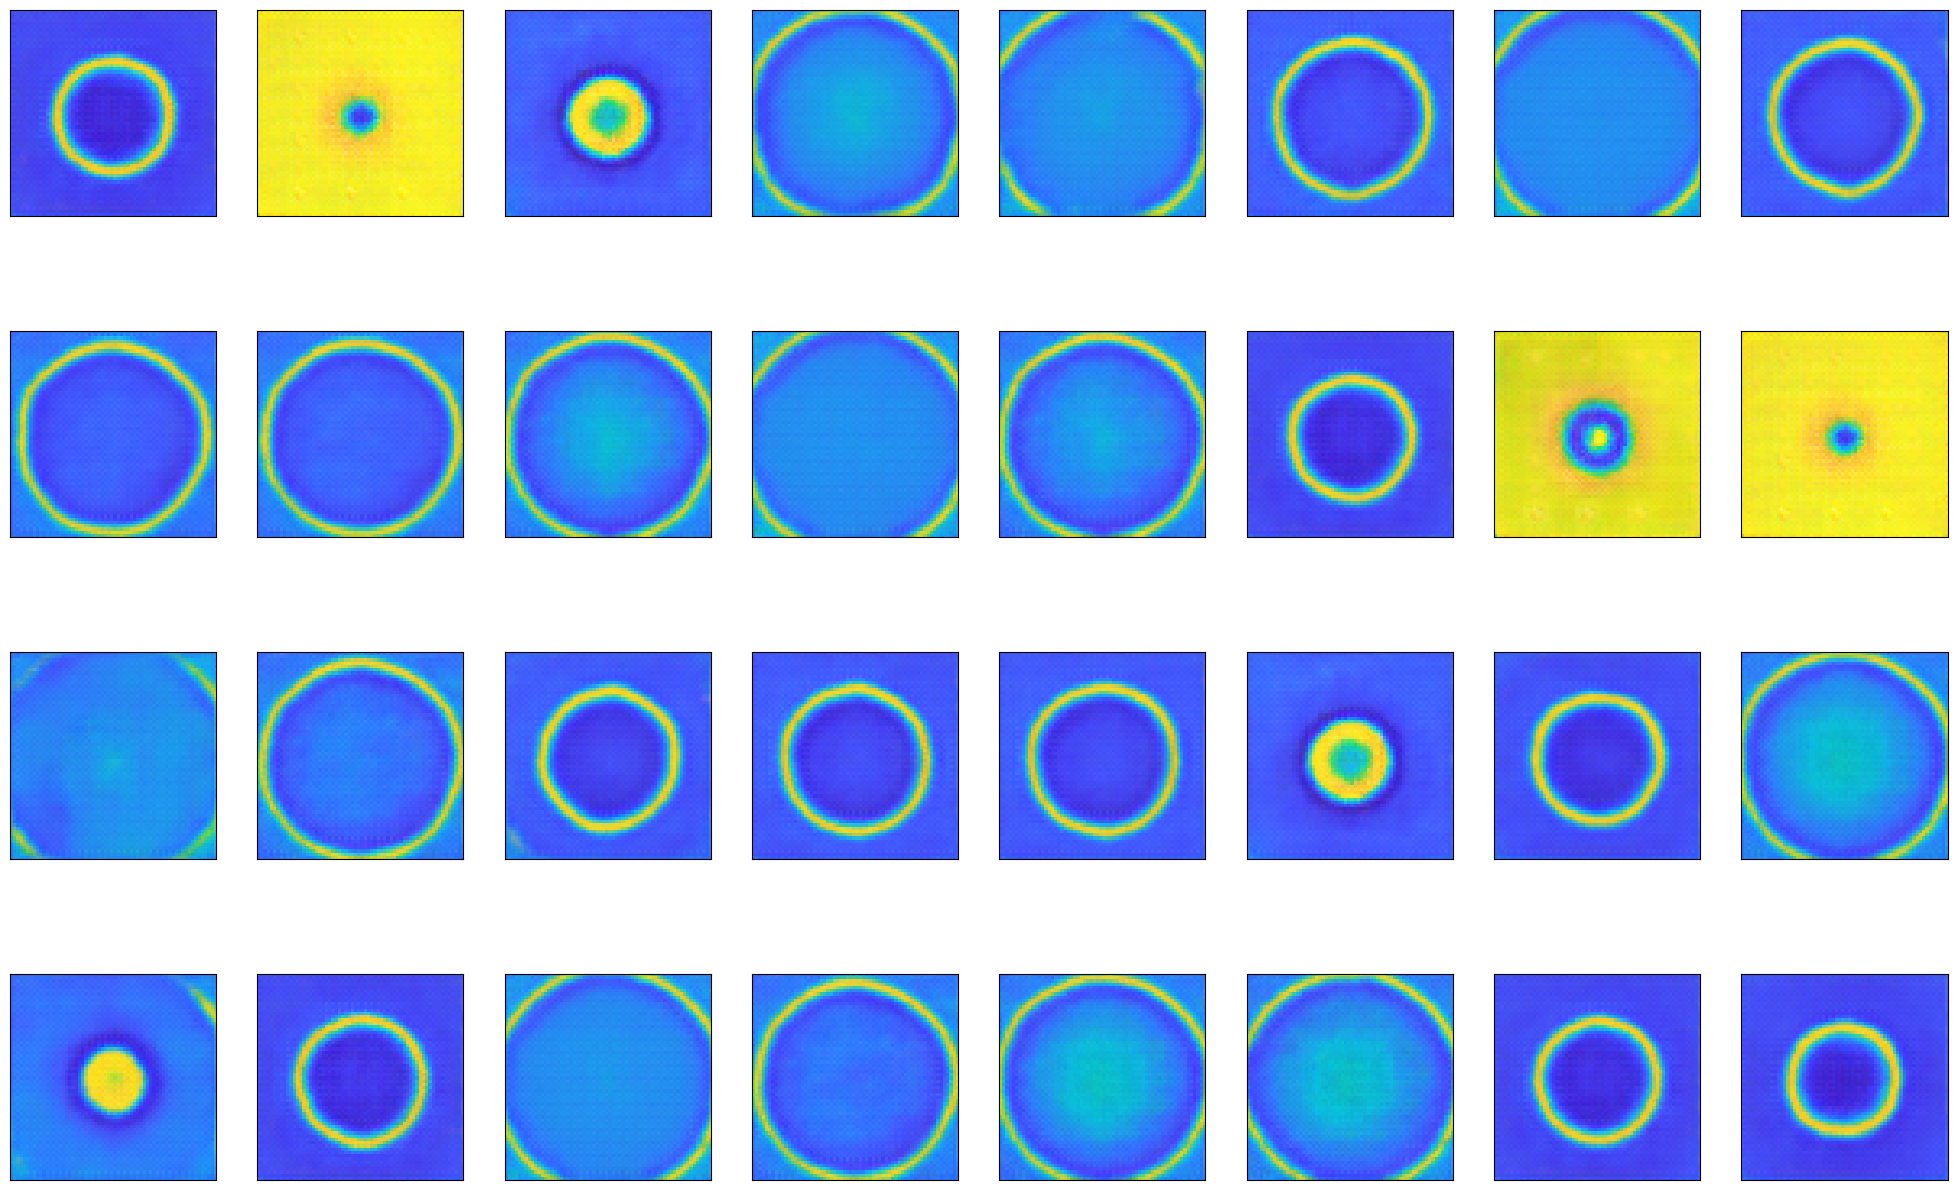

Generating images for: 600  epochs

 Saving Model
**********


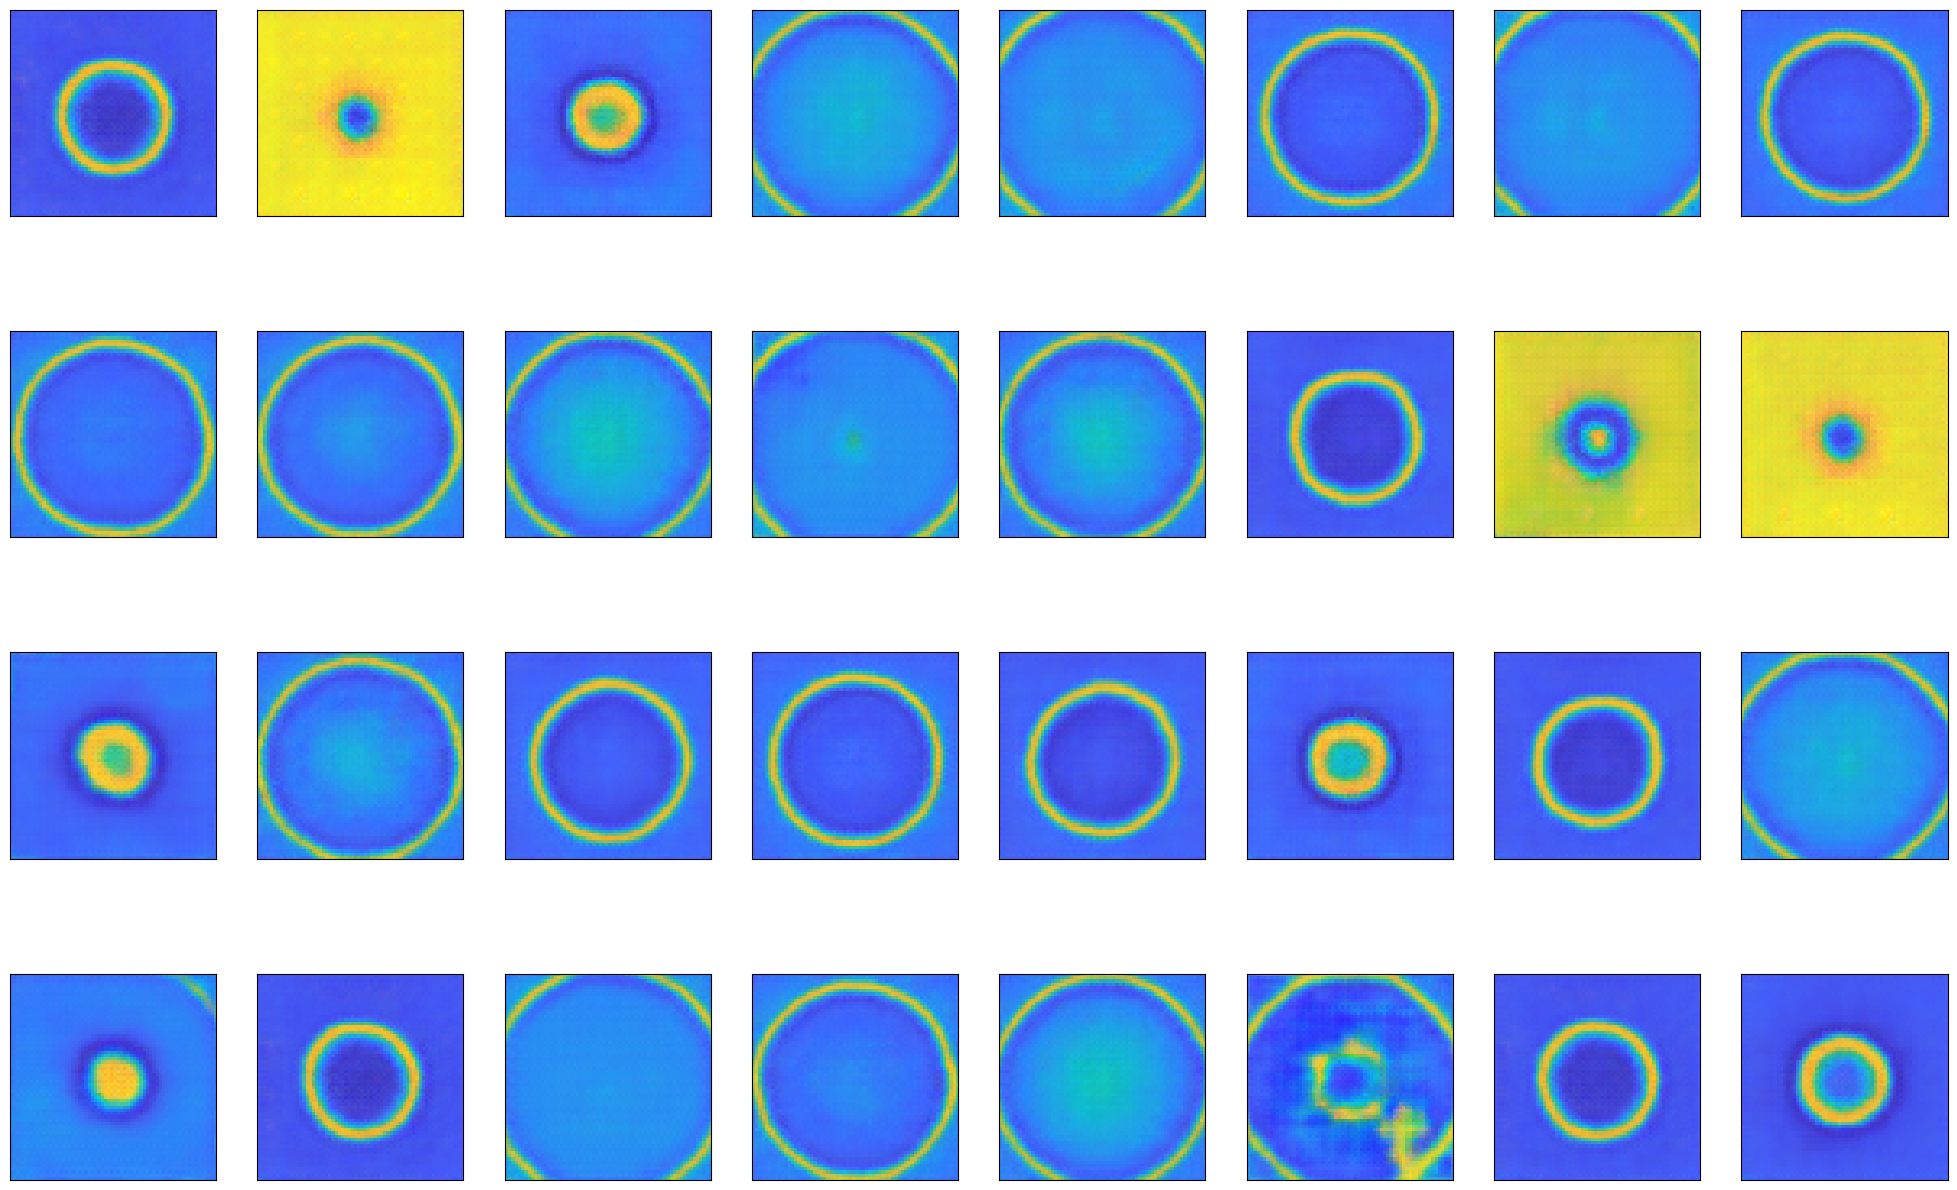

Generating images for: 700  epochs

 Saving Model
**********


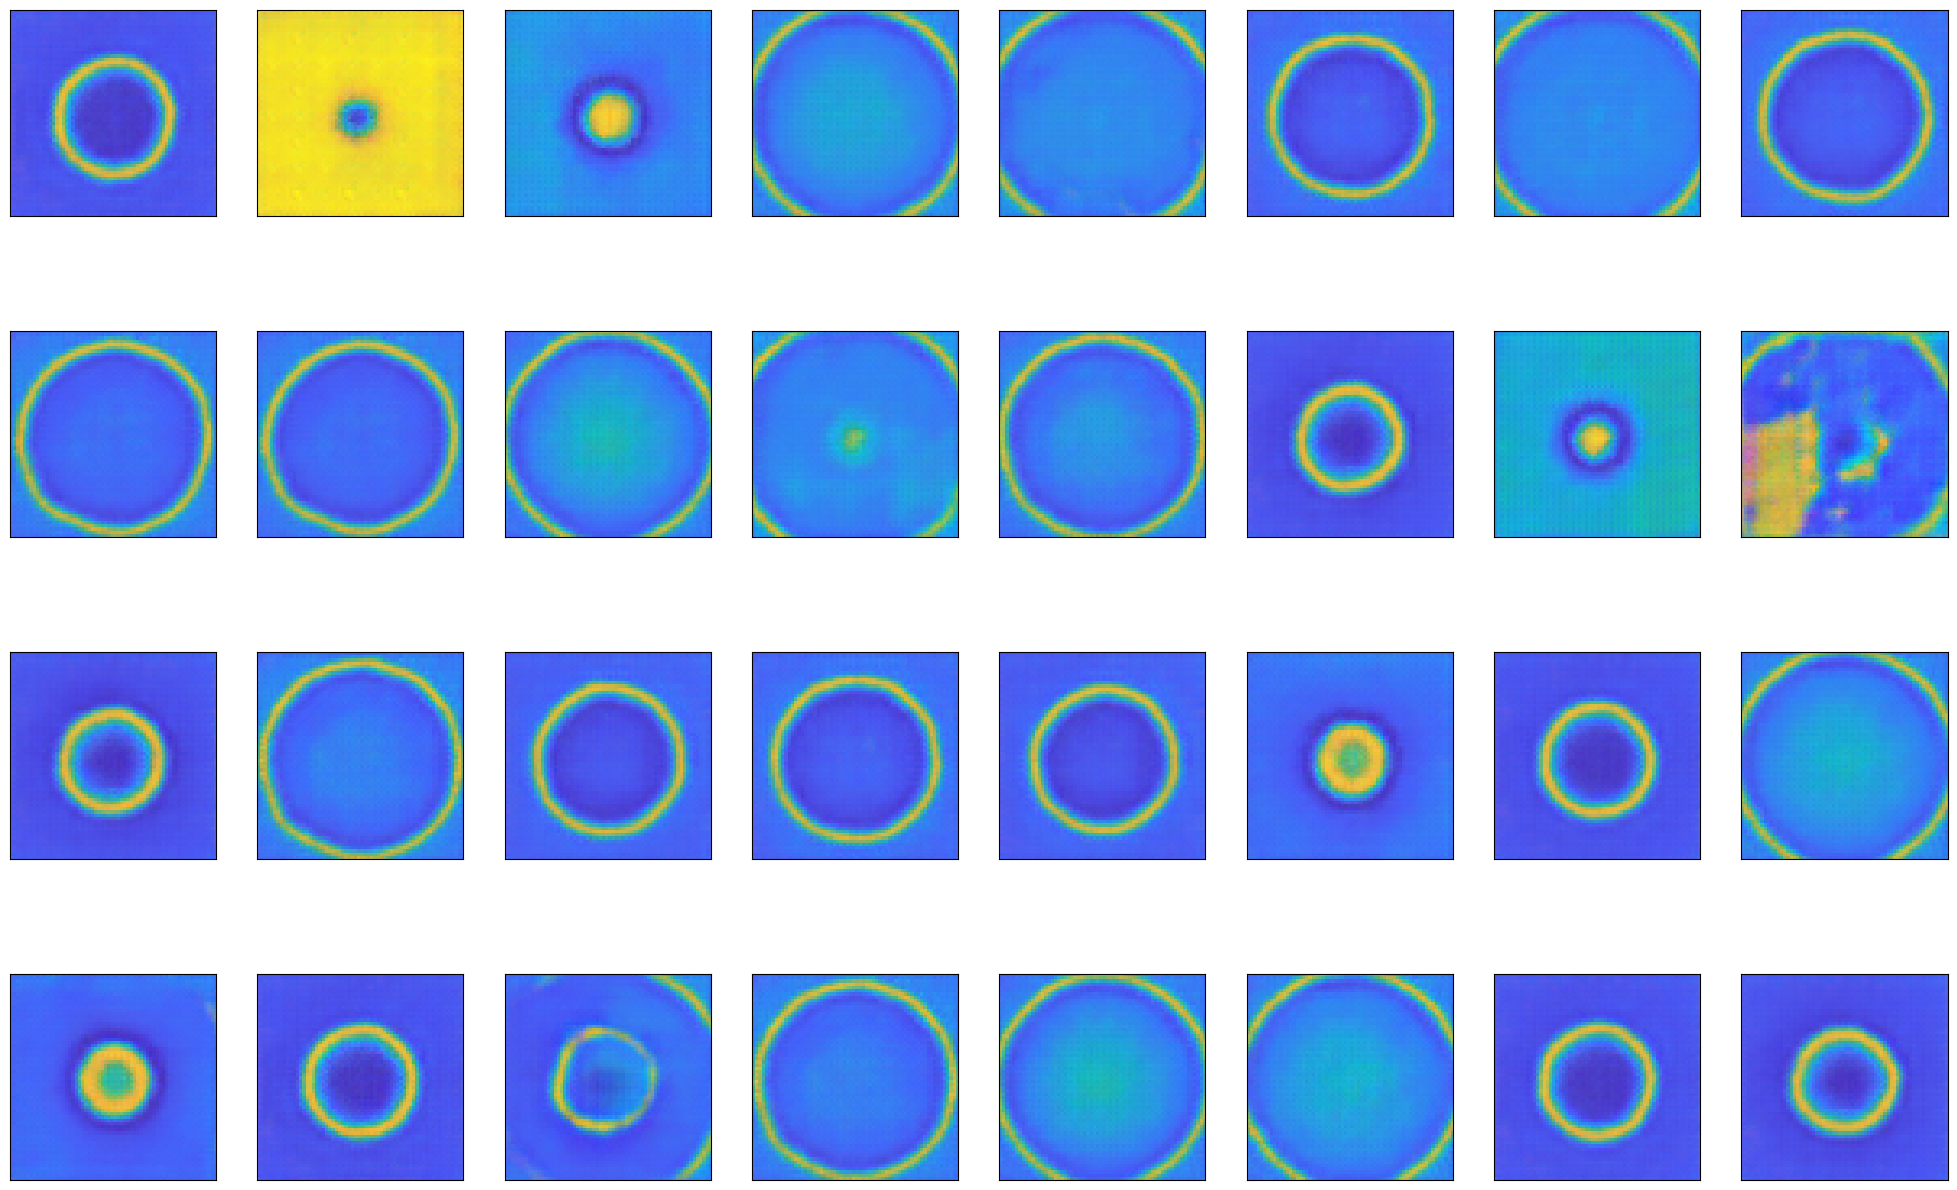

Generating images for: 800  epochs

 Saving Model
**********


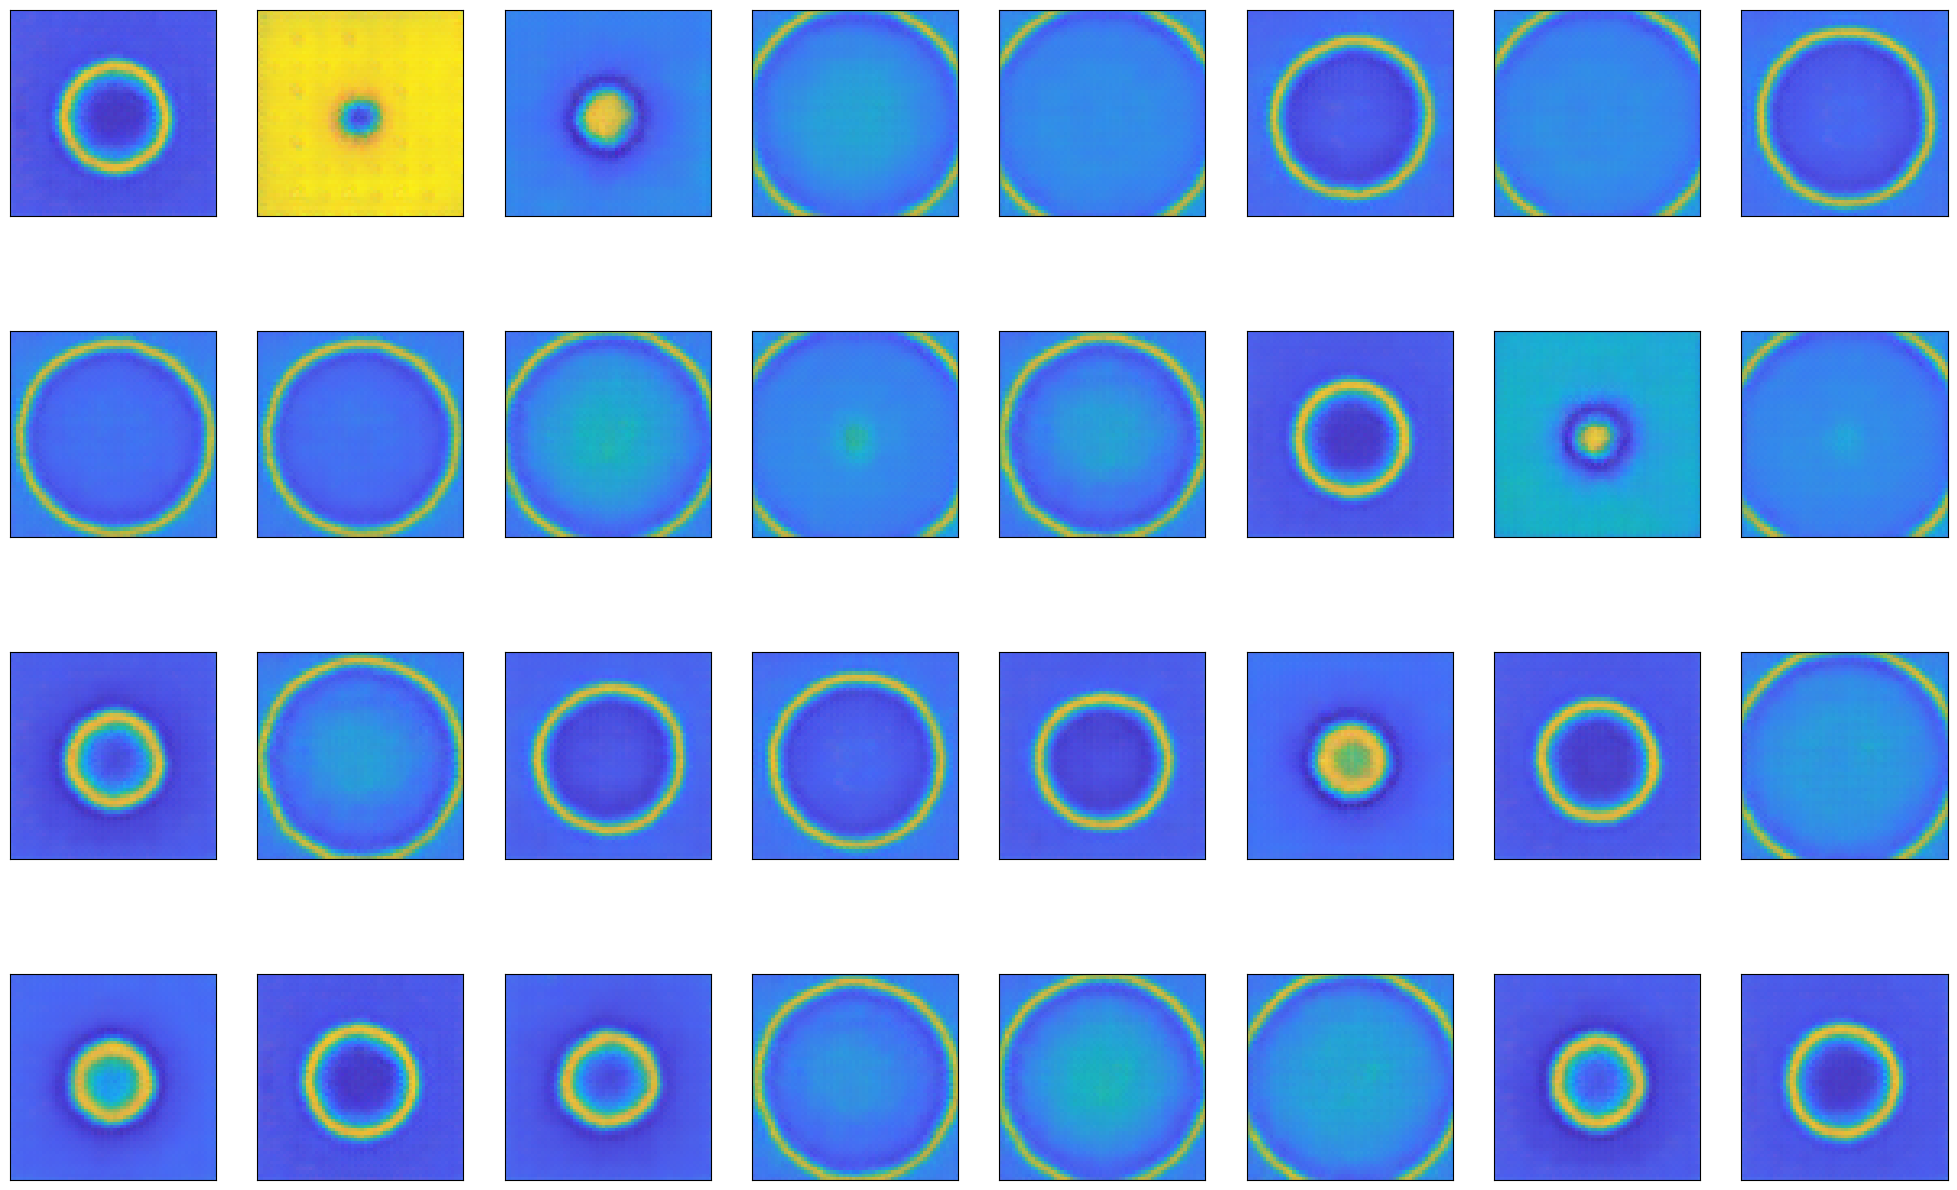

Generating images for: 900  epochs

 Saving Model
**********


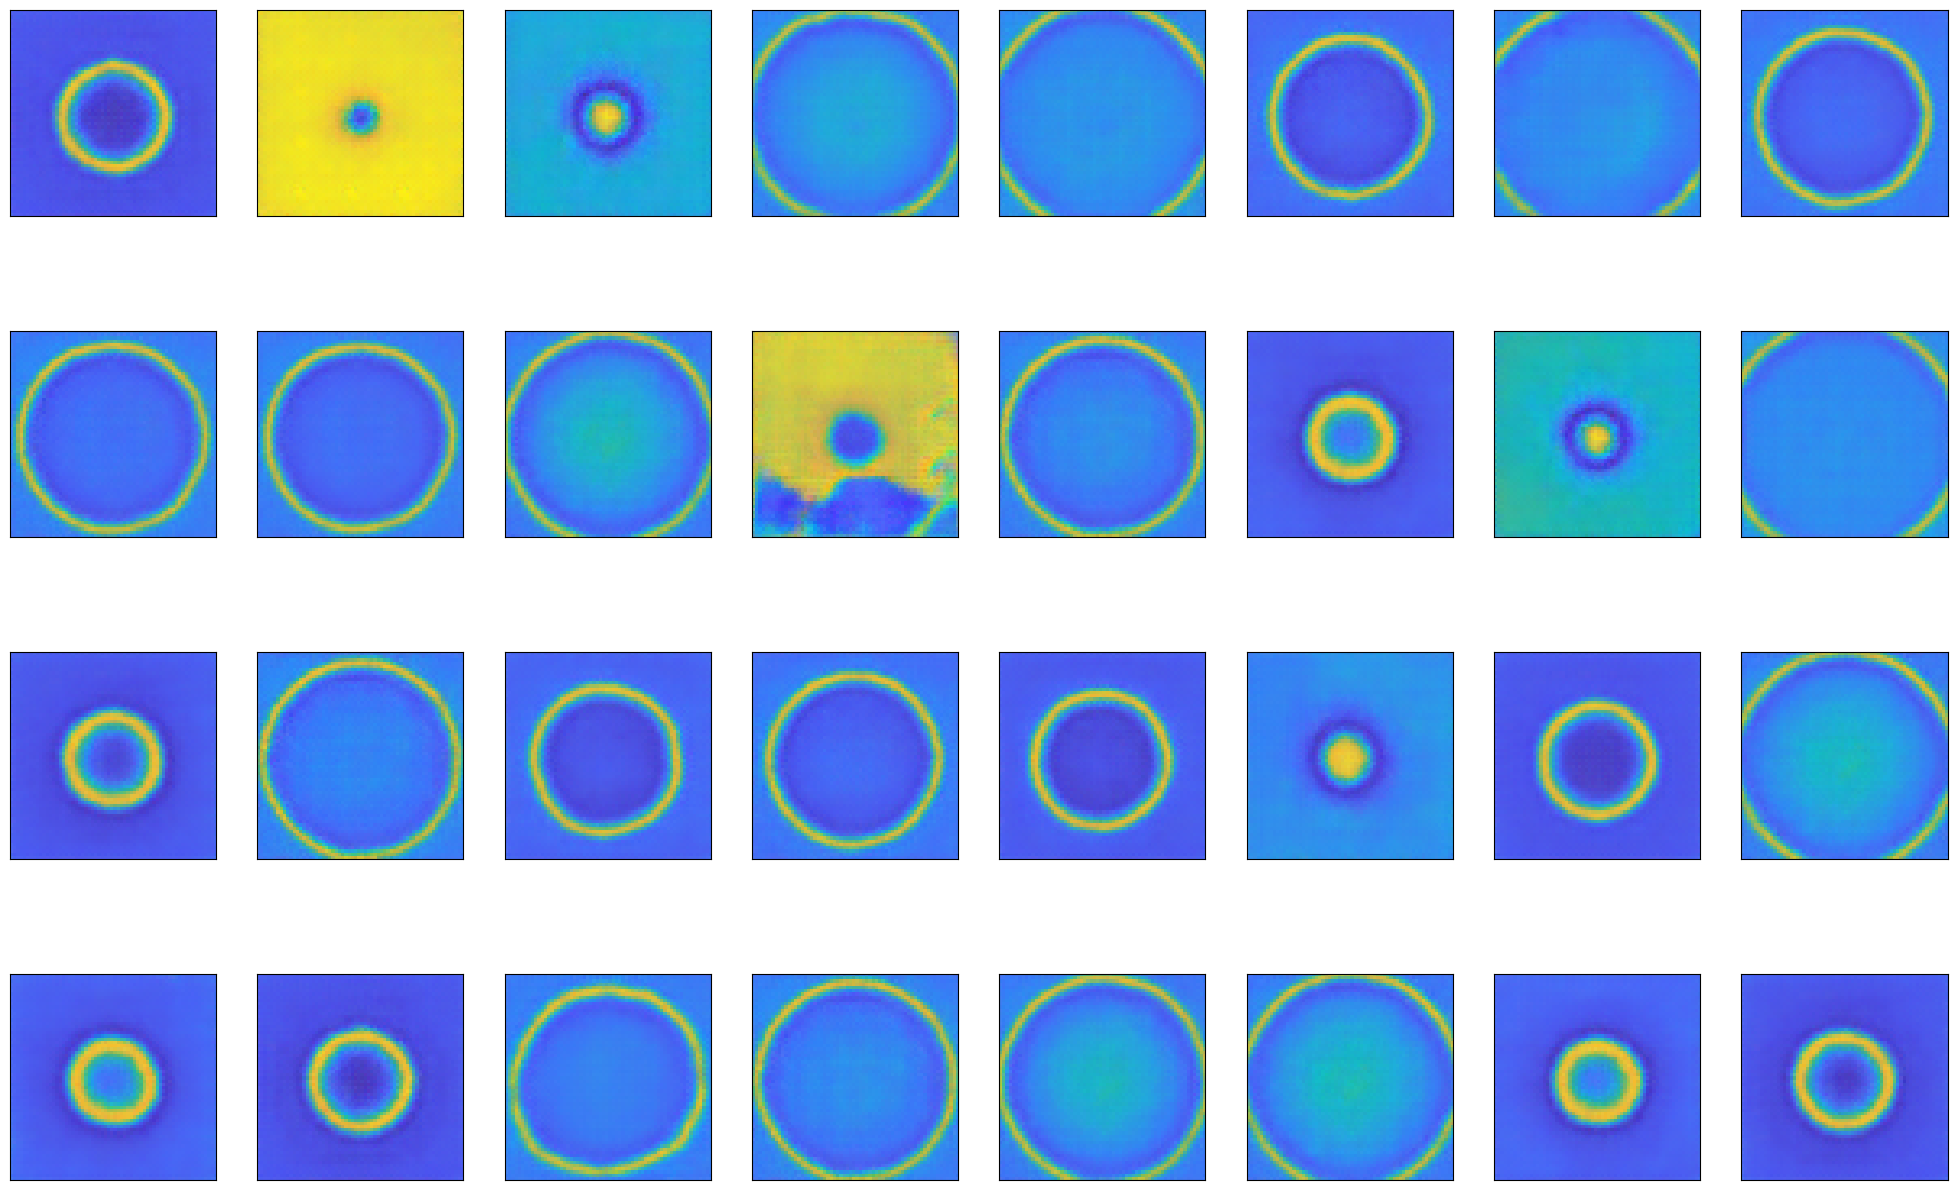

**********

 Finished Training with lr = 0.001, batch_size=13, epochs=1000, nz=30
**********

 Saving Model
**********
**********

 Generating Images with lr = 0.001, batch_size=13, epochs=1000, nz=30
**********


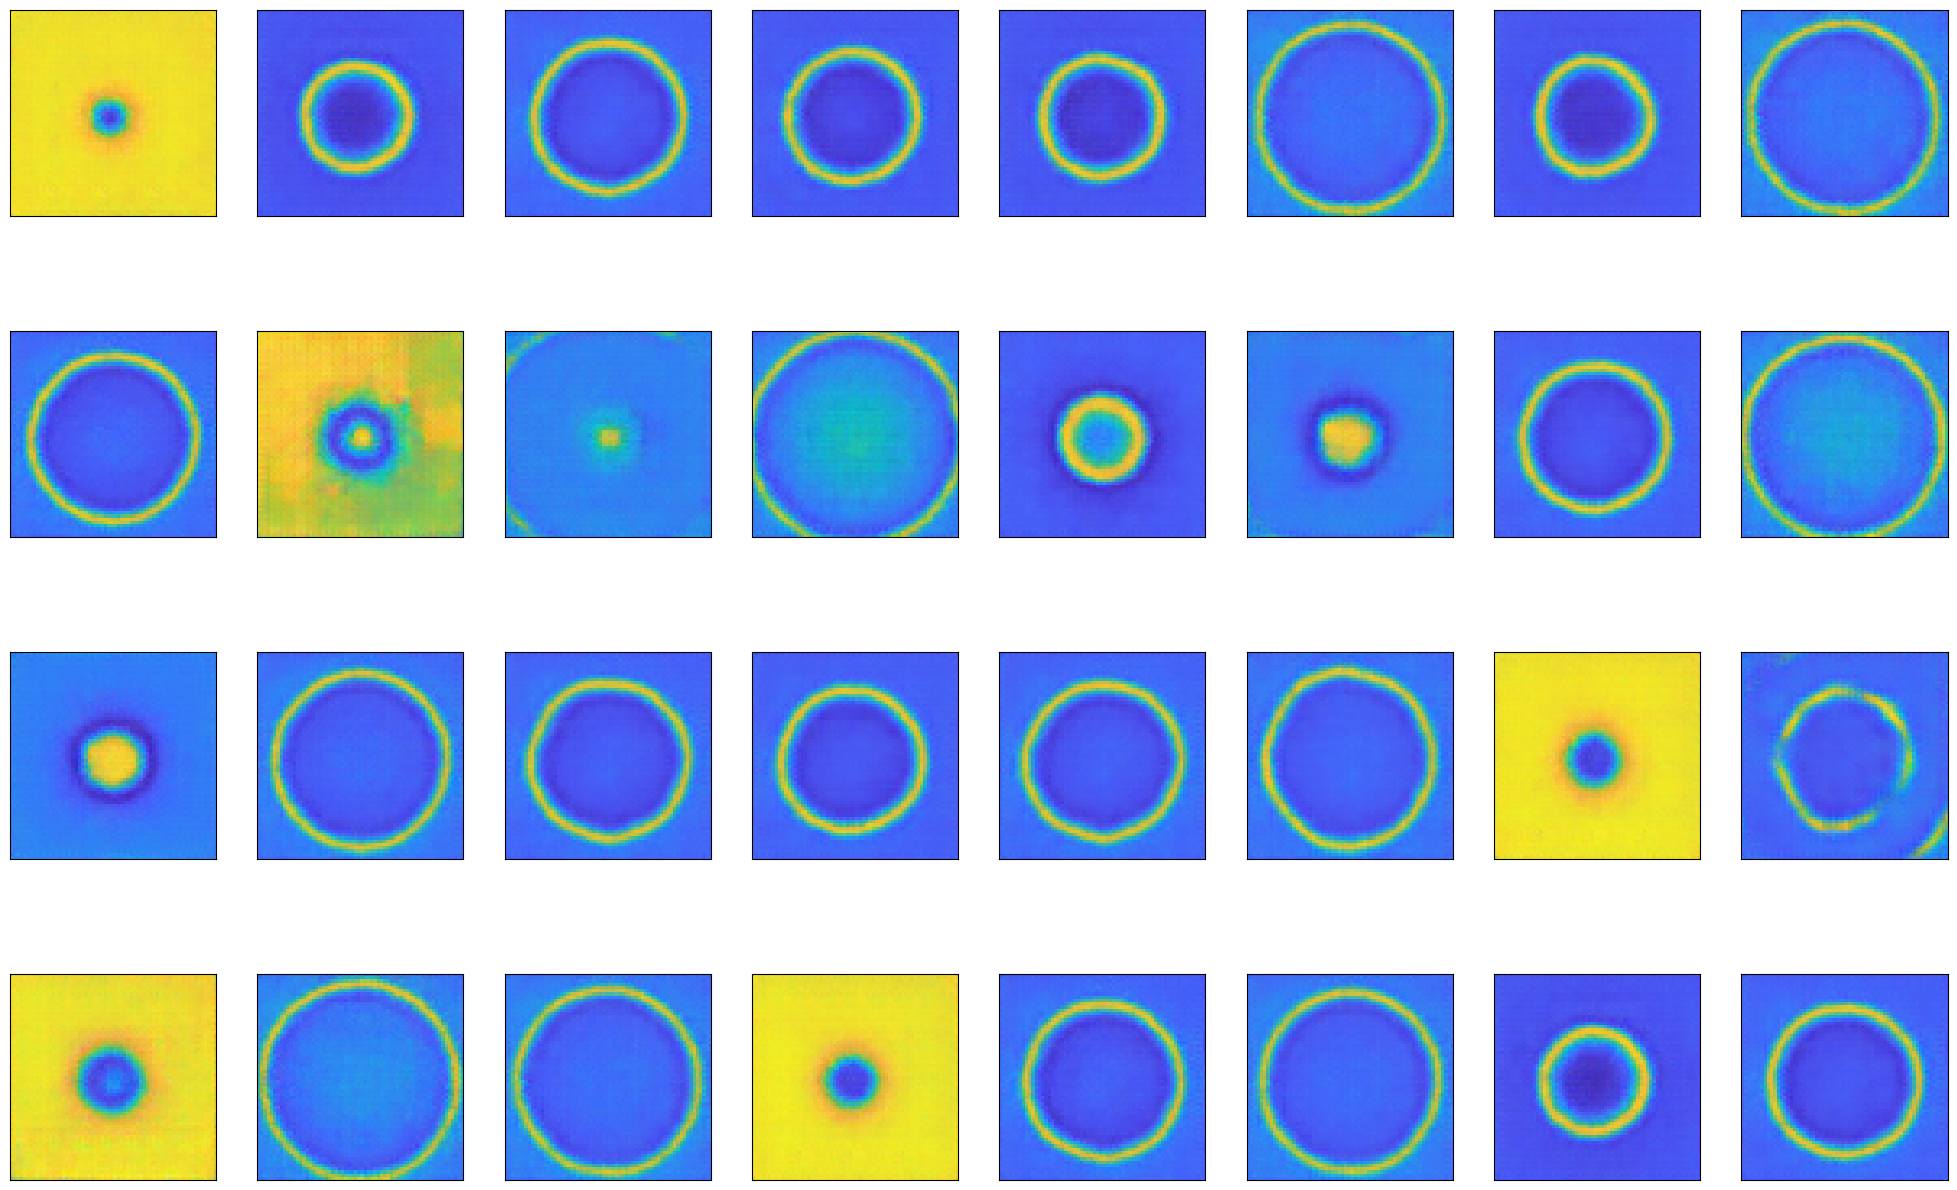

**********

 Saving Images with lr = 0.001, batch_size=13, epochs=1000, nz=30
**********


In [10]:
import torch
# Iterate through combinations of parameters
for lr in lr_sizes:
    for batch_size in batch_sizes:
        for epochs in epochs_values:
            for nz in nz_values:
                # Training parameters
                print(f"\nTraining with lr = {lr}, batch_size={batch_size}, epochs={epochs}, nz={nz}")
                beta1 = 0.5

                # Labeling for discriminator
                real_label = 0.5
                fake_label = 0

                # Setting up the device for training
                device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  

                # Run your training and evaluation code
                trainData(batch_size, nz, epochs, lr)

#             # Check if current configuration is better than the previous best
#             if accuracy > best_accuracy:
#                 best_accuracy = accuracy
#                 best_parameters = {'batch_size': batch_size, 'epochs': epochs, 'nz': nz}

# Print the best configuration
# print(f"\nBest Configuration: {best_parameters}, Best Accuracy: {best_accuracy}")